# Estimating Preciptation in Alaska Using Surface Regression (12 points)


## Introduction

In this part of the project, your goal is to perform a 3D surface regression which will fit a model that will allow us to estimate the total amount of precipitation during the month of July 2020 at any longitude/latitude pair that falls in the state of Alaska.

Our estimation will be based off of datasets maintained by the National Oceanic and Atmospheric Administration (NOAA) which provides free access to a variety of weather and climate datasets. You can access the full dataset that we use here: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00332. 

When performing any kind of data analysis one, of the first steps is to get a feel for the data. That can mean many things from understanding the size of the dataset, peeking at what the data looks like (does it contain string values, integers, floats) and exploring if there is missing data, to name just a few aspects of interest. 

## Pro tips: Hit save periodically while working in this notebook. You can submit multiple times because we only grade the last submission. 

# For best results, when submitting your FINAL notebook, use the ```Restart Kernel & Clear Output``` option above. When the autograder is run, it re-runs all cells from scratch. By clearing your outputs, you erase the (often large) plots in the output too, which makes the file super compact. All of your code remains intact. We promise! For intermediate submissions, you can just hit submit, without clearing your outputs. And if on the final submit you forget to clear your outputs, it should be fine... 

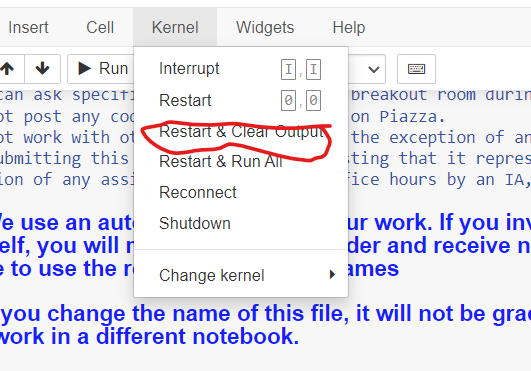

In [ ]:
using LaTeXStrings, LinearAlgebra, CSV, ProgressBars, Printf, Random, DataFrames

In [ ]:
using Plots;  # Issue with plots and Julia 1.8.1
# Cell may fail. The next one will run fine. 
# Just go with it. 
# You have done nothing wrong.


In [ ]:
using Plots  # Issue with plots and Julia 1.8.1

In [ ]:
# We use import here because the GMT package also has a plot function
# that would override the plot function made available with the Plots
# package. Thus any function in the GMT package needs to be called
# GMT.function_name(...)

import GMT

# Set the plotting backend to gr
gr()


### The next set of cells read in our dataset and visualize the information.

__Dataset Citation__ : Vose, Russell S., Applequist, Scott, Squires, Mike, Durre, Imke, Menne, Matthew J., Williams, Claude N. Jr., Fenimore, Chris, Gleason, Karin, and Arndt, Derek (2014): Gridded 5km GHCN-Daily Temperature and Precipitation Dataset (nCLIMGRID), Version 1. 202007.prcp.alaska.pnt. NOAA National Centers for Environmental Information. DOI:10.7289/V5SX6B56 Aug 1, 2020.

In [ ]:
# Run me, don't change me. I will upload a dataset
# to this notebook and also display the size and first 
# five rows of the data. 
# the csv file must stay in the same folder as this notebook
df = CSV.read("202007_prcp_alaska.csv", DataFrame, header=false)
data = Matrix(df)

@show typeof(data);
@show size(data);

# Print out the first five rows
data[1:5,:]

## The dataset we have just read in contains 3 columns. The first column contains longitude values which range from -180 to 0 (western hemisphere) or 0 to 180 (eastern hemisphere). The second column contains latitude values which we can think of as horizontal slices across the world. Latitude values can range from 0 to 90 (northern hemisphere) or -90 to 0 (southern hemisphere).  The third and final column contains total precipitation information in millimeters.

### Note:  300 mm = 30 cm = 1 foot of rain


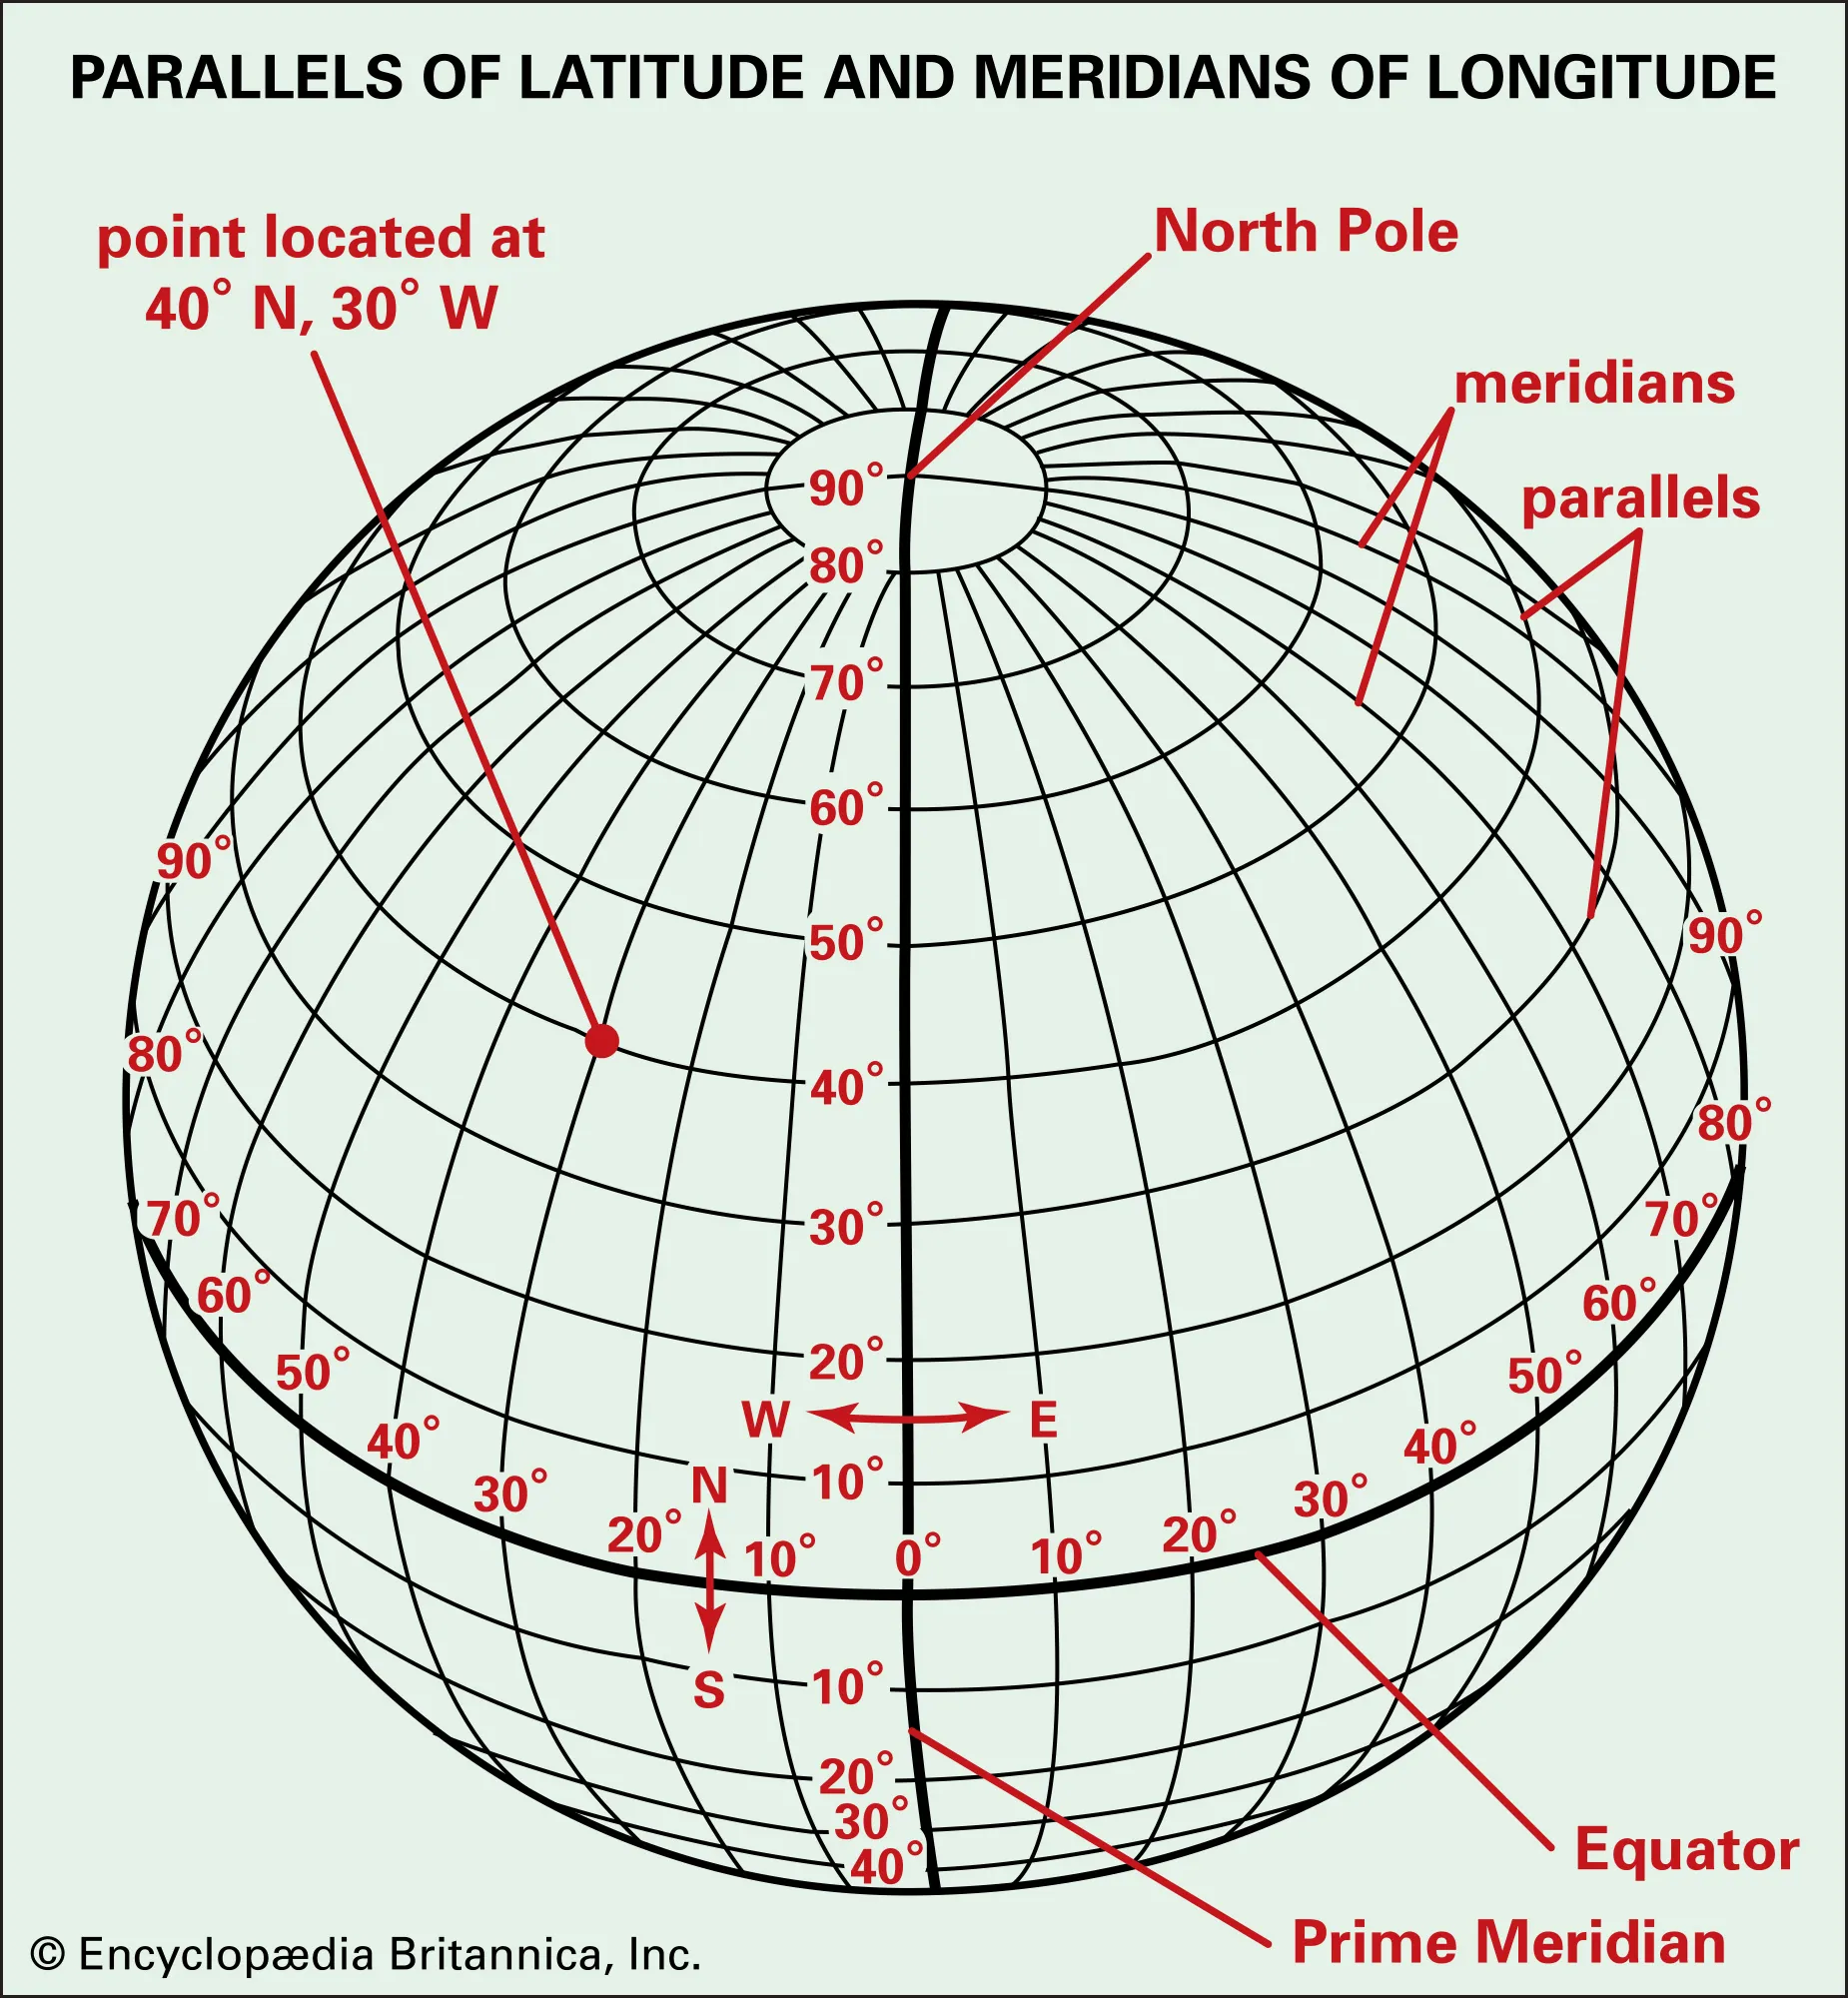

**Image from https://www.britannica.com/science/latitude**

# In the following, we give you the data you will use when building your regressor matrix $\Phi$ and when assigning the vector of measured values, $Y$. Please make a note of them.

In [ ]:
# Run me, don't change me
# Split the data into geometric coordinates and precipitation values
# You will use these later in this notebook
dataLongLat=data[:,1:2] # to be used when building Phi
dataPrecip=data[:,3] # measured values
@show size(dataLongLat) 
@show length(dataPrecip) 

## This being a larger dataset, let's create a scatter plot using the location of a small portion of the samples to further get a sense of the dataset and the values within it. We will use the provided sample function to do this.

In [ ]:
# Run me, don't change me. I am a function that returns 
# a portion of the dataset based on the percentage provided

#=
Samples a percentage of the rows of matrix 'data'

Input:
    data    - data matrix to sample rows from
    percent - 0 < percent <= 100
=#
function sample_rows(data, percent)
   
    @assert percent > 0 && percent <= 100
    
    N = size(data, 1)
    M = floor(Int64,percent*N/100)
    
    # Set's the initial condition of the random number generator
    # so that every notebook will arrive at the same results
    Random.seed!(1817);
    center_indices = collect(1:N); 
    indices = shuffle(center_indices)[1:M]
    
    col1 = data[indices, 1]
    col2 = data[indices, 2]
    prcp = data[indices, 3]
    
    # Assemble columns using horizontal concatenation
    # concatenation in this case means placing side by side
    subset = hcat(col1, col2, prcp)

    return subset
end

In [ ]:
# Run me, don't change me! I sample and display the locations
# of 1.5% of the measurements in our dataset
percent = 1.5 

dataSubset = sample_rows(data, percent)
centers = dataSubset[:,1:2] # We only want the geometric data for the centers

s1 = scatter(
    centers[:,1], 
    centers[:,2], 
    markersize=1,
    label="Measurements",
    xlabel="Longitude",
    ylabel="Latitude",
    title="Locations of Precipitation measurements"
)

## After running the scatter function, you should be able to see the shape of Alaska take form. Each (x,y) point corresponds to a (longitude, latitude) pair in the dataset. 

Another view of the data would be to visualize the precipitation value at each point. We make use of the GMT package's bar3 function to create a 3D plot of the precipitation recorded at each location. Before being able to call the function, however, we need to section up Alaska into a series of bins. Imagine placing a checkerboard over the above graph. Each square in the checkerboard will have a (lon,lat) pair associated with it. Each measurement will be placed in the square that it's closest to. We will take an average if there are squares that have more than one measurement associated with it. 

The pixelate function below helps us with taking our data, and turning it into the grid we described. Note, you only need to understand the inputs and outputs to the function, not all of the code. 

In [ ]:
# Run me, don't change me!

#=
pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

Takes a 3D matrix (lon,lat,rain) and returns a grid where each pixel is 
equal to the average of all the rain measurements that fall into that pixel

Inputs:
    data      - the data set
    n_xpixels - the number of pixels on the x axis (longitude)
    n_ypixels - the number of pixels on the y axis (latitude)

Output:
    grid      - a n_ypixels x n_xpixels matrix holding the average 
                rain that fell in that location
=#
function pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

    # (lon,lat) coordinates with measured rain in third column
    @assert size(data, 2) == 3
    
    # No nan values exist in data
    @assert !any(isnan.(data))
    
    xmin = min(data[:,1]...)
    xmax = max(data[:,1]...)
    ymin = min(data[:,2]...)
    ymax = max(data[:,2]...)
    
    xedges = collect(range(floor(xmin), ceil(xmax), length=n_xpixels))
    yedges = collect(range(floor(ymin), ceil(ymax), length=n_ypixels))
    
    grid = zeros(n_ypixels, n_xpixels)
    count = zeros(n_ypixels, n_xpixels)
    
    for i in 1:size(data,1)
        x_idx = searchsortedlast(xedges, data[i,1])
        y_idx = searchsortedlast(yedges, data[i,2])
        
        grid[y_idx, x_idx] += data[i,3]
        count[y_idx, x_idx] += 1
    end
    
    grid = grid./ count
    
    # Replace Nan from divide by 0 with 0
    replace!(grid, NaN=>0)
        
    return GMT.mat2grid(grid, x=xedges, y=yedges) 
end

In [ ]:
# Run me, don't change me! I create a 3D bar graph that
# displays the precipitation across the state of Alaska

grid = pixelate(dataSubset, 100, 100)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
         xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

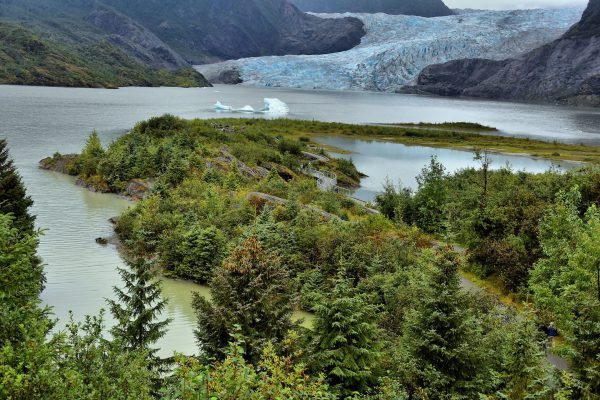We see that for most of the state of Alaska, not a lot of precipitation fell. However, near the south of Alaska where the state capitol Juneau resides, there was quite a bit of precipitation that fell relative to the rest of the state in July. And indeed it is quite beautiful there in the summer! 

__Reference__: https://www.weather-us.com/en/alaska-usa/juneau-climate


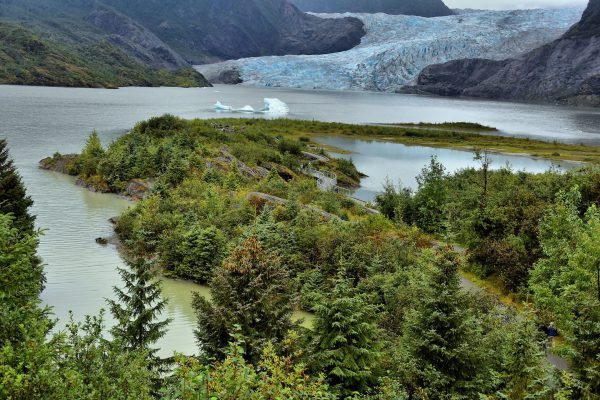

If you try plotting a higher percentage of measurement samples, you may feel that the 3D bar plot is already dense enough. However, note that each degree of difference in latitude/longitude is approximately 50-70 miles apart depending on where you are in the world (closer to the equator or pole etc.) Additionally, we wish to be able to create a model that allows us to estimate the precipitation level at any (longitude, latitude) pair at infinite resolution.

### In the rest of the notebook, you will create a model that will be able to estimate the amount of precipitation that fell during the month of July anywhere in Alaska. To do this, you will perform a surface regression using the radial functions as your basis.


## Here is a new RBF function that works for vectors

In [ ]:
# Run me, don't change me. I define an RBF for vectors.

# Radial basis function
rbf(x, xc, s) = exp.(-norm(x-xc)^2 / (2*s^2))

In [ ]:
# Run me, don't change me. I show you how to use the above RBF 
# with vectors instead of scalars
#
using LinearAlgebra # Just in case you have not run it recently
x = [3 4] # Each Longitude-Latitude data pair is a 2-vector
xc = [3.5 4.5] # Each center is also a 2-vector 
s = 1
rbf(x, xc, s)

# Expected output is 0.7788007830714049

# This is SUPER IMPORTANT as you progress in the notebook. What is the difference between the `length` command and the `size` command? How do you index into matrices vs vectors?

# Vectors are indexed like this myVector[i], while matrices are indexed like this 
1. myMatrix[i,j] or
2. myMatrix[i,:] or myMatrix[i:i,:] or
3. myMatrix[:,j]
4. and never like this myMatrix[i]

## Most of the struggles we have seen with this part of the project involve students misusing the length command in place of the size comamnd or forgetting how to index into matrices. (Stress does strange things to the human mind.) We reviewed indexing above and we review examples of the size command below.

In [ ]:
A=randn(20,30)
@show nRows,nCols = size(A) # How to get number of rows and columns
@show nRows = size(A, 1) # How to get ONLY the number of rows 
@show nCols = size(A, 2) # How to get ONLY the number of columns 
@show length(A) # length of a matrix has no use in this project

### Please notice that length of a matrix is the PRODUCT nRows*nCols, which is its total number of entries

### In this Project, you NEVER EVER EVER want to apply length to a matrix. Only apply it to vectors.

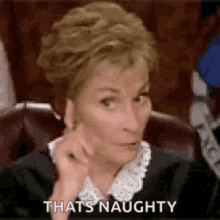
Judge Judy!

# Making use of the fine work we did in Part 1


## In the cell below, copy over from p1_basis_functions the functions
* ```backwardsub```
* ```forwardsub```
* ```least_squres_lu```

## You will want them for solving the regression problem in this part of the project.


In [ ]:
# Fill me in so that you can solve regression problems

#=
forwardsub(L, b)

It solves for x in an equation Lx = b, where L is lower triangular.
=#

#=
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
=#

#= function least_squares_lu(Phi::Array{Float64,2},  Y::Array{Float64,1})

It solves for α* = arg min ||Phi alpha - Y||^2
=#

# YOUR CODE HERE


In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

PhiTest = [ 1 1.0; 1 2; 1 4; 1 5]
YTest = [2; 3.2; 4.7; 6]
alphaStarTest=least_squares_lu(PhiTest,YTest)
display(alphaStarTest)
is_it_correct_check1 = (norm(alphaStarTest- [1.125000000000001;  0.9499999999999996]) < 1e-4) ? "Yes" : "No" 

@show is_it_correct_check1;
println(" ")
println("If you failed this test, but passed it in Part 1, then you did not copy over all of the required functions")

### Reminder: dataLongLat=data[:,1:2] is a MATRIX and was defined many cells above. You will need it for the x-values in the RBF function 

### You will also need a set of centers for the x_c values in your RBF function. They are defined in the next cell. Look below for centersLongLat=centers[:,1:2]




In [ ]:
s = 1
percent = 1.5 

# Do not modify the percent or s. If you do so, you will mess
# up the answers used in the friendly tests and the autograder. Ouch!

centers = sample_rows(data, percent)
centersLongLat=centers[:,1:2]
@show size(centers)
@show size(centersLongLat)


#### Task 3: Build a Regression Model to Predict the Precipitation in Alaska (4+4+2+3 points)

### Part A (4 points): Modify the Helper Functions  ```calc_phi_row``` and ```regressor_matrix``` to allow for passing in data that is now in $\mathbb{R}^2$. 

**When editing the following cell, as we have stressed multiple times now, be very careful with the `size` command and the `length` command. Recall our previous remark that when you apply `length(matrix)` it returns the total number of entries in the matrix (the PRODUCT of the number of rows and columns in the matrix), which is typically not what you are after. Instead, you want the number of rows or columns in the matrix, such as `nRows = size(A,1)`, `nCols = size(A,2)`, or `nRows, nCols = size(A)`.**

**Think carefully about the variables being used in your function. Are they scalars, vectors, or matrices? As we have reminded you, that changes how you index into them, right?**


## The next cell has you take the function ```calc_phi_row(xᵢ, centers, s)``` from Part 1 and modify it to work here where xi is a vector, centers is a matrix and s remains a scalar.


In [ ]:
# Modify me to work with xi in R2 and centers being a matrix. 

# We copied the code from the previous notebook that worked for xi a real number. 

# You should check the sizes of your inputs as given in the function definitions 
# and modify the code to work for 2-dimentional spaces! 



#  From Part 1 of the project. You might uncomment it and make edits as needed

# function calc_phi_row(xᵢ, centers, s)
#     # xi is a scalar
#     # centers is a vector of centers for the rbf basis elements
#     # s is the scale value
#     NumBasisElements = length(centers) + 1
#     # plus one abave because we also include a constant vector
#     phi_row = zeros(1, NumBasisElements)
#     phi_row[1] = 1    
#     for i in 2:NumBasisElements
#         phi_row[i] = rbf(xᵢ, centers[i-1], s)
#     end    
#     return phi_row
# end


# Your modified function still only needs a SINGLE for loop. 
# You DO NOT need a nested for loop.


function calc_phi_row(xᵢ, centers, s)
    
    # YOUR CODE HERE
    
    return phi_row
end


In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong
dummy_dataLongLat = [1 3;2 4;3 5;4 6;5 7;6 8;7 9;8 10;9 11]
dummy_centers = [2 5; 4 7; 5 6]
phi_row_1_test = calc_phi_row(dummy_dataLongLat[1,:], dummy_centers,1)
phi_row_5_test = calc_phi_row(dummy_dataLongLat[5,:], dummy_centers,1)

is_it_correct_check1 = isapprox(phi_row_1_test, [1.0  0.082085  3.72665e-6  3.72665e-6], atol = 1e-3) ? "Yes" : "No"
is_it_correct_check2 = isapprox(phi_row_5_test, [1.0  0.00150344  0.606531  0.606531], atol = 1e-3) ? "Yes" : "No"

@show is_it_correct_check1;
@show is_it_correct_check2;

println("dummy centers")
display(dummy_centers)
println("dummy dataLongLat")
display(dummy_dataLongLat)

## This next part has you take your function  ```regressor_matrix``` from Part 1 and modify it to work here. It will not work as is. You have to make edits.

## Build the regressor matrix row by row using a SINGLE for loop and your modified function ```calc_phi_row(xᵢ, centers, s)```. Once again, be very careful about the sizes of the variables in your function and be careful about how you index into matrices vs vectors.

## We strongly suggest that you check size(centersLongLat), and while you are at it, you can also check size(dataLongLat). Hit the plus sign to create a new cell in which you can run these tests.

In [ ]:
# Modify me to work with xi in R2!

# We copied the code from the previous notebook that worked for xi in R1. 
# You should check the sizes of your inputs as given in the function definitions 
# And try to modify the code to work for 2-dimentional spaces! 

#=
function regressor_matrix()

Returns the regressor matrix Phi

Inputs:
    X       - an Nx2 matrix holding the X value of all the measurements
    centers - an Mx2 matrix holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

# Code from Part 1 of the Project for you to use as a starting point
#
# function regressor_matrix(X, centers, s)
#     # X is a vector of points in R
#     # centers is a vector of centers for the rbf basis elements
#     # s is the scale value    
#     N = length(X)
#     M = length(centers)
#     Phi = Array{Float64, 2}(undef, N, M+1)   
#     for i in 1:N
#         Phi[i, :] = calc_phi_row(X[i], centers, s)
#     end 
#     return Phi
# end

# length vs size! Vector vs Matrix!
# The code from Part 1 is just a starting point!

function regressor_matrix(X, centers, s)
    
    # YOUR CODE HERE
    
end


##  Our Friendly Checks are meant to be helpful but they are NOT meant to be a guarantee. You alone are resposible for your work. 

## The regressor matrix is very important to this project. At the top of the cell where you built the regressor matrix function, we indicated its dimensions. You should check your function on some simple data to at least make sure the size of the regressor matrix is correct.

In [ ]:
# If your function is correct, this will be its output on some simple test data

#= 
9×4 Matrix{Float64}:
 1.0  0.00673795   4.13994e-8   1.12535e-7
 1.0  0.367879     0.00673795   0.0183156
 1.0  0.00673795   0.367879     1.0
 1.0  4.13994e-8   0.00673795   0.0183156
 1.0  3.09882e-12  1.25015e-9   3.72665e-6
 1.0  0.135335     0.135335     0.367879
 1.0  4.53999e-5   0.135335     0.367879
 1.0  5.10909e-12  4.53999e-5   0.00012341
 1.0  1.92875e-22  5.10909e-12  1.38879e-11
=#

# Uncomment the line BELOW  to run your function regressor_matrix on some simple test data
# regressor_matrix([1 2; 3 4; 5 6; 7 8; 9 3; 4 5; 6 7; 8 9; 10 11], [2 5; 4 7; 5 6], 1)

## Part B: Calculate the model weights (4 points)

### Now, you will setup the regression problem and use the functions implemented above to solve for the vector of weights ```a_star```. Note that even though our data has grown in dimension, we are still using the same model for fitting as in the end of notebook 1! As we saw when we plotted 1% of of the points, we could make out the shape of Alaska. Thus 1% of the data provides decent enough coverage of the state, so we will use those locations as our basis centers. 

### In the next cell write the code necessary to solve for the coefficients of our model ```a_star```.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

## We are expecting you to use your function ```least_squares_lu``` in order to compute a_star

In [ ]:
# Compute a_star
# Once again, we are expecting you to use your 
# function ```least_squares_lu``` in order to compute a_star
# but we do not check for that. You can use any method you wish.

# YOUR CODE HERE

# End the pipeline here
@show size(dataLongLat)
@show size(centersLongLat)
@show size(Phi)
@show length(a_star)

println(" ")
println("Recall that a_star includes a constant term, which is why it is 
    one longer than the number of rows in centersLongLat")
println(" ")
@show (a_star[1:5])

In [ ]:
# Checking the first five elements as a friendly test! If assert does not complain, you are good
ans1 = isapprox(a_star[1:5], [41.02774014953474, 3001.0797227419307, 163844.96534774158, 28363.22655160181, 7288.967977936066], atol = 0.001)

is_it_correct_check1 = ans1 ? "Yes" : "No"

@show is_it_correct_check1;

## Now your task is to put it all together: build a function that computes the amount of precipitation at any position x=[lon; lat] in Alaska. 

# Hint: Look back at how we built the function f_hatRBF(x) for you in ```p1_basis_functions```. You can go to the notebook and search on f_hatRBF

In [ ]:
# build your function and call it Precip(x)
#
# The above cell tells you how to go about it
#
# Precip(x)=??


In [ ]:
# friendly check
if isa(Precip([-159.159, 70.5409]), Vector) || isa(Precip([-159.159, 70.5409]), Matrix)
    println("Your `Precip(x)` function implementation is wrong.")
    println("Your `Precip(x)` function should return a real-valued number and not a Vector.\n")
    println("Extract the number from the Vector before returning it from your `Precip(x)` function")
    println("See the Lab Manual for how to that.")
else
    println("Good. Your `Precip(x)` function returns the right value Type.")
    println("Now on to the remaining friendly check...\n")
    println("Is the value returned correct? \n")

    # if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
    # If the value of is_it_correct_checkN is "No", then your answer is wrong

    is_it_correct_check1 = isapprox(Precip([-159.159, 70.5409]), 21.89695, atol=1e-1) ? "Yes" : "No"   

    @show is_it_correct_check1; 
end;

In [ ]:
Precip([-159.159, 70.5409])

## Part C: Inference (2 points)

With your model approximation, you can now provide an estimate of the precipitation at any longitude and latitude pair in Alaska. As a quick example, let's test and see based on our model, how much precipitation in millimeters fell in Juneau, Alaska in July. We will use a longitude and latitude of (-134.410652, 58.301930) obtained from Google maps. You should see a value between 290 and 320 mm.

In [ ]:
# If you do not pass the test, take
# a look back at how you calculated a_star. Also, check to see
# that you did not change the value of s, or percent.


lon = -134.410652
lat = 58.301930
# Note: Remember Points in our data array are arranged as [lon, lat, precipitation]
# and these measured values were taken at specific locations where sensors 
# were installed. (measured data is not available for all possible locations in Alaska)
# Your function Precip(x) will predict the amount of precipitation for ANY location x = [lon; lat]

# rain_in_juneau = ??


In [ ]:
@printf("In July 2020, our model predicts that a total of %.2f mm of rain fell in Juneau, Alaska.", rain_in_juneau)

## Part D: Plot the Surface (3 points)

Now we estimate the precipitation that fell over the entire state of Alaska at discretized (longitude, latitude) pairs. Because, we did not get any precipitation measurements off of the coast of Alaska (measurements were only taken over land), we only estimate with our model if the (lon,lat) coordinate falls approximately on land. Your job is to fill in the code in the space provided (second cell below).

In [ ]:
# Run me, don't change me. I divide up the state of Alaska into
# a series of squares that looks like a checkerboard / grid. In 
# the next cell we evaluate the precipitation for each square 
# in the grid.

# Latitude and longitude extremas of Alaska
lon_min = -178.0
lon_max = -130.0
lat_min = 51.0
lat_max = 72.0

# Number of squares we want on the x and y axis for plotting our 3D bar graph
n_xpixels = 200
n_ypixels = 200

lon_edges = collect(range(floor(lon_min), ceil(lon_max), length=n_xpixels));
lat_edges = collect(range(floor(lat_min), ceil(lat_max), length=n_ypixels));
gmt_grid = pixelate(data, n_xpixels, n_ypixels);

The next cell is used to estimate the precipitation across Alaska. ```mat[i,j]``` should hold the precipitation that fell at lon/lat which are set at the beginning of the inner for loop each time. Use the model you just fit along with the available helper functions to estimate the precipitation and set the value in ```mat[i,j]```.

In [ ]:
# Modify me in the space below.

mat = zeros(n_ypixels, n_xpixels)
for i = 1:n_ypixels
    for j = 1:n_xpixels
        lon = lon_edges[j]
        lat = lat_edges[i]
        
        # Do not estimate if coordinate is not on land
        # We check this by seeing if there was any measured
        # precipitaton near that lon,lat pair in the original data set
        if gmt_grid.z[i,j] > 1e-6
            
            # YOUR CODE HERE:
            # mat[i,j] = ??
  
        end
    end
end
@printf("Maximum rain in any place in alaska measured %0.1f mm \n",maximum(mat))  
@printf("There was on average %0.1f mm of precipitation in Alaska in June 2020", sum(mat)/(length(lat_edges)*length(lon_edges)))

## There is no Friendly Test cell of the matrix ```mat```. Your test is to compare your plot to the one below.

In [ ]:
grid = GMT.mat2grid(mat, x=lon_edges, y=lat_edges)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
    xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

# Congratulations, you have fit a surface to the dataset! 

## You can check your plot by comparing it against this figure

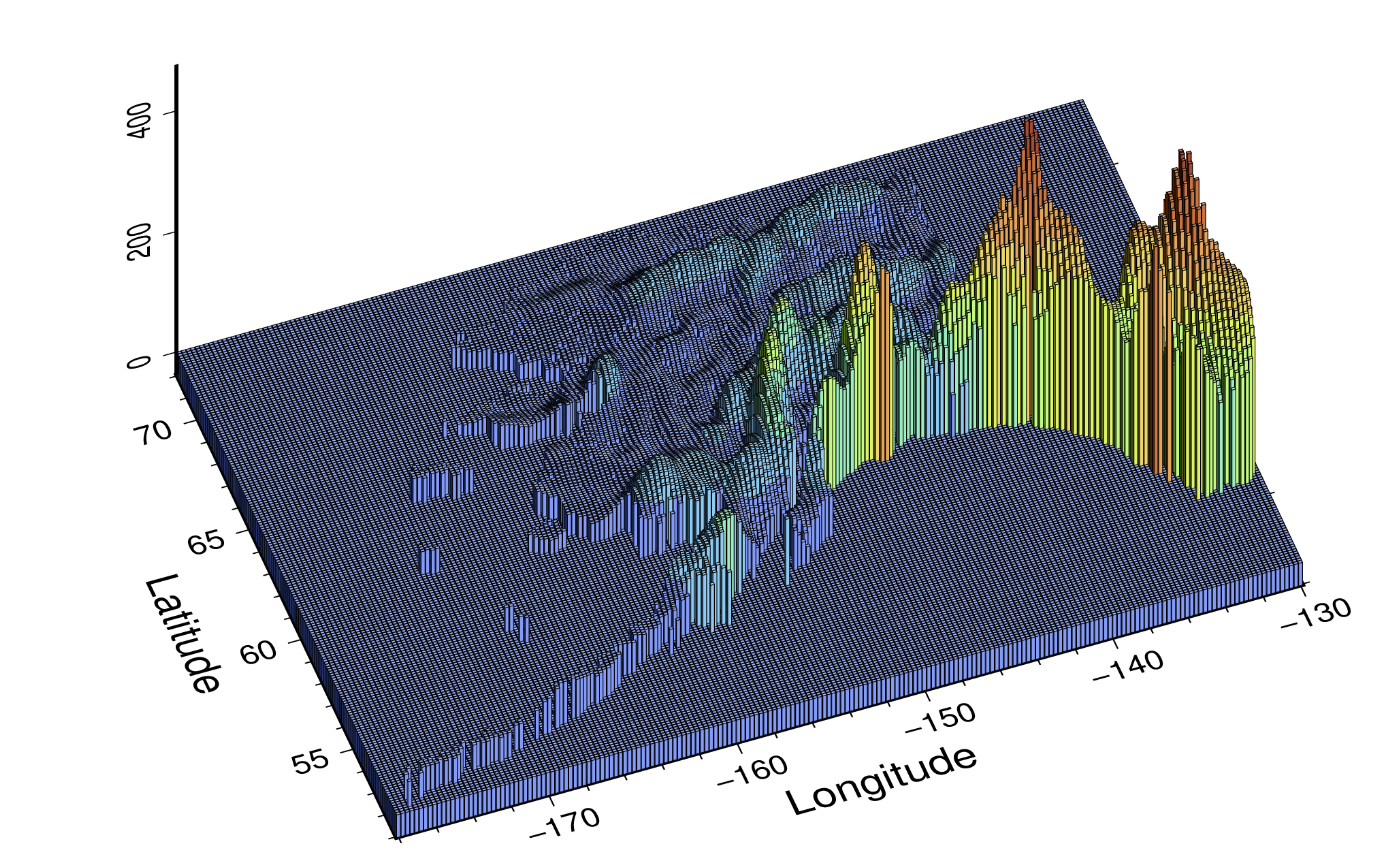

# Don't forget to hit the submit button once you have completed this part as well. Remember, you can submit as many times as you want. We grade the last submission.

## It is possible to produce a good final plot and yet have made errors along the way that cancel one another out. Our Friendly Checks are meant to be helpful but they are NOT meant to be a guarantee. You are resposible for checking your work as you go. 

### If you have completed this part, go ahead and hit the submit button. Remember, you can submit as many times as you want. We grade the last submission. 

### For best results, when submitting your FINAL notebook, use the ```Restart Kernel & Clear Output``` option shown below. When the autograder is run, it re-runs all cells from scratch. By clearing your outputs, you erase the (often large) plots in the output too, which makes the file super compact. All of your code remains intact. We promise! For intermediate submissions, you can just hit submit, without clearing your outputs. And if on the final submit you forget to clear your outputs, it should be fine... 

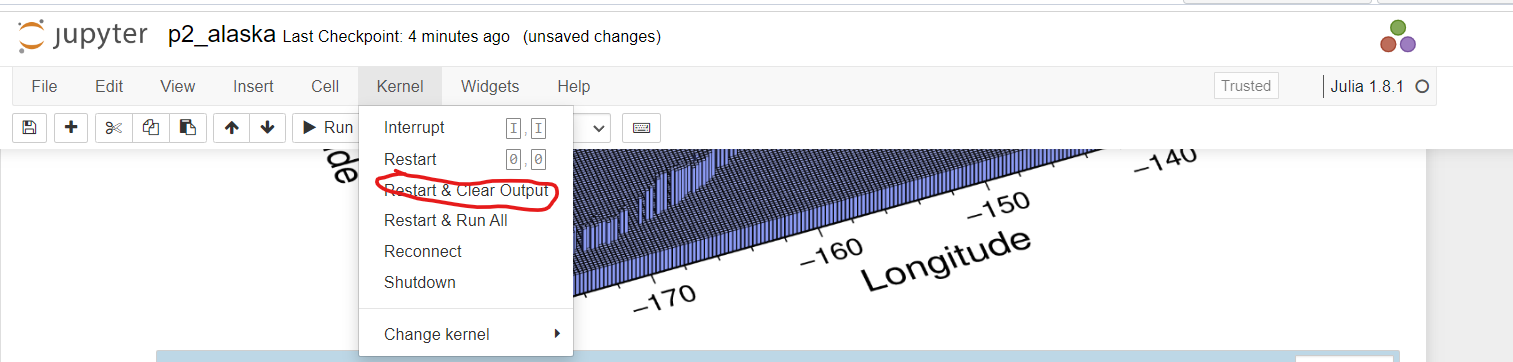